# Bayesian sampling diagnostics

In [1]:
import arviz as az
import dill
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm

In [2]:
# Load black for formatting
import jupyter_black

jupyter_black.load()

In [3]:
# Supress select warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="arviz")
az.rcParams["plot.max_subplots"] = 60

In [4]:
# Set global Seaborn theme
sns.set_theme(
    style="white",  # White background
    context="notebook",  # Default context; adjust font sizes for notebooks
    rc={
        "axes.spines.top": False,  # Remove top spine
        "axes.spines.right": False,  # Remove right spine
        "axes.grid": False,  # Disable gridlines
        "xtick.bottom": True,  # Enable bottom ticks
        "ytick.left": True,  # Enable left ticks
        "xtick.major.size": 6,  # Length of major x-axis ticks
        "ytick.major.size": 6,  # Length of major y-axis ticks
        "axes.titlesize": 13,  # Font size for titles
        "axes.labelsize": 11,  # Font size for axis labels
        "legend.fontsize": 11,  # Font size for legends
    },
)

# Set Matplotlib defaults
plt.rc("font", family="sans-serif")  # Use a sans-serif font
plt.rc("axes", titlesize=13, labelsize=11)  # Font sizes for axes and titles
plt.rc("xtick", labelsize=11)  # Font size for x-tick labels
plt.rc("ytick", labelsize=11)  # Font size for y-tick labels
plt.rc("figure", figsize=(6, 5))  # Default figure size

## Plotting functions

In [5]:
def plot_observed_and_predictive_distr(
    y_obs: np.array,
    y_obs_trans: np.array,
    y_prior_pred: np.array,
    y_posterior_pred: np.array,
    titles: list[str],
):
    """
    Plot four distributions in a 2x2 grid: observed data, transformed observed data,
    prior predictive sample, and posterior predictive sample.

    Args:
        - y_obs: Observed data.
        - y_obs_trans: Transformed observed data.
        - y_prior_pred: Prior predictive sample.
        - y_posterior_pred: Posterior predictive sample.
        - titles: List of subplot titles.
        - figsize: Size of the figure.
    """

    # Create figure and 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    alpha = 0.6
    bins = 50

    # Plot observed data
    sns.histplot(y_obs, bins=bins, kde=False, alpha=alpha, ax=axes[0, 0])
    axes[0, 0].set_title(titles[0])
    axes[0, 0].set_xlabel("Relative abundance")
    axes[0, 0].set_ylabel("Frequency")

    # Plot transformed observed data
    sns.histplot(y_obs_trans, bins=bins, kde=False, alpha=alpha, ax=axes[0, 1])
    axes[0, 1].set_title(titles[1])
    axes[0, 1].set_xlabel("Relative abundance")
    axes[0, 1].set_ylabel("Frequency")

    # Plot prior predictive sample
    sns.histplot(y_prior_pred, bins=bins, kde=True, alpha=alpha, ax=axes[1, 0])
    axes[1, 0].set_title(titles[2])
    axes[1, 0].set_xlabel("Relative abundance")
    axes[1, 0].set_ylabel("Frequency")

    # Plot posterior predictive sample
    sns.histplot(y_posterior_pred, bins=bins, kde=True, alpha=alpha, ax=axes[1, 1])
    axes[1, 1].set_title(titles[3])
    axes[1, 1].set_xlabel("Relative abundance")
    axes[1, 1].set_ylabel("Frequency")

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

In [6]:
def trace_plot(
    trace,
    var_names,
):
    axes = az.plot_trace(
        data=trace,
        var_names=var_names,
        divergences="bottom",
        compact=False,  # Plot multidimensional variables in one plot
        combined=False,  # Combine chains into a single line
    )

    plt.tight_layout()
    plt.show()

In [7]:
def plot_prior_distribution(prior_samples, category, variable):

    if category == "prior":
        data = prior_samples.prior
    elif category == "prior_predictive":
        data = prior_samples.prior_predictive
    else:
        data = prior_samples.observed_data

    az.plot_dist(
        data[variable],
        figsize=(6, 3),
        kind="hist",
        color="C1",
        hist_kwargs=dict(alpha=0.6, bins=50),
    )

    plt.title(f"{category}: {variable}", fontsize=12)

    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)

    max_ticks = 15
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    plt.xticks(rotation=45)

    plt.show()

## Load (training) data

In [8]:
# Load the model output dictionary and get data
training_output_path = (
    "../../data/runs/run_folder_2025-01-09_21.07.54/training_output.pkl"
)

with open(training_output_path, "rb") as in_stream:
    training_output = dill.load(in_stream)

train_data = training_output["data"]
df_pred_train = training_output["state_predictions"]
state_metrics_train = training_output["state_metrics"]
df_pred_change_train = training_output["change_predictions"]
change_metrics_train = training_output["change_metrics"]
train_model = training_output["model"]
train_trace = training_output["trace"]
train_prior_predictive = training_output["prior_predictive"]

In [9]:
# Extract variables for analysis and plotting

# Observed values and prior predictive samples
y_obs = df_pred_train.get_column("Observed")
y_obs_trans = df_pred_train.get_column("Observed_transformed")
y_prior_pred = train_prior_predictive.prior_predictive["y_like"].values.flatten()
y_posterior_pred = train_trace.posterior_predictive["y_like"].values.flatten()

## Observed data, prior and posterior predictive distributions

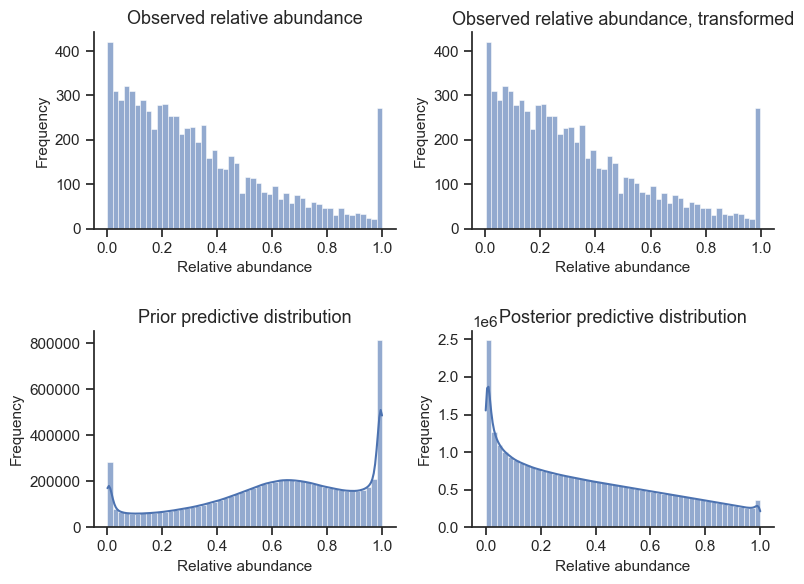

In [10]:
plot_observed_and_predictive_distr(
    y_obs=y_obs,
    y_obs_trans=y_obs_trans,
    y_prior_pred=y_prior_pred,
    y_posterior_pred=y_posterior_pred,
    titles=[
        "Observed relative abundance",
        "Observed relative abundance, transformed",
        "Prior predictive distribution",
        "Posterior predictive distribution",
    ],
)

Sampling: [y_like]
INFO:pymc.sampling.forward:Sampling: [y_like]


Output()

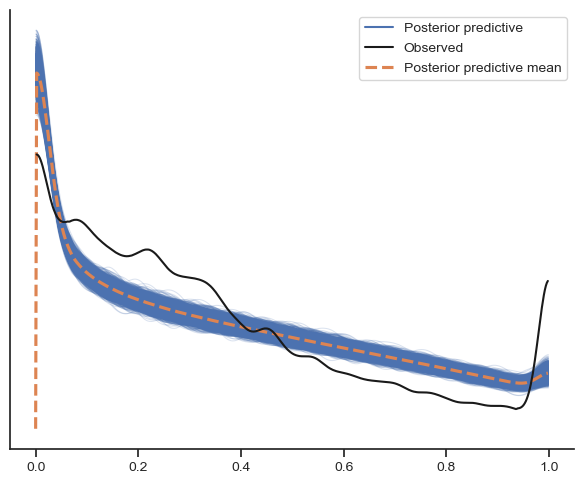

In [11]:
with train_model:
    train_trace.extend(pm.sample_posterior_predictive(train_trace))

ax = az.plot_ppc(train_trace)
for label in ax.get_xticklabels():
    label.set_fontsize(10)
plt.xlabel("")
ax.legend(fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()

## Trace plot inspection

/Users/jakny386/miniconda3/envs/bio_impact/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (30) is smaller than the number of variables to plot (46), generating only 30 plots
  warnings.warn(


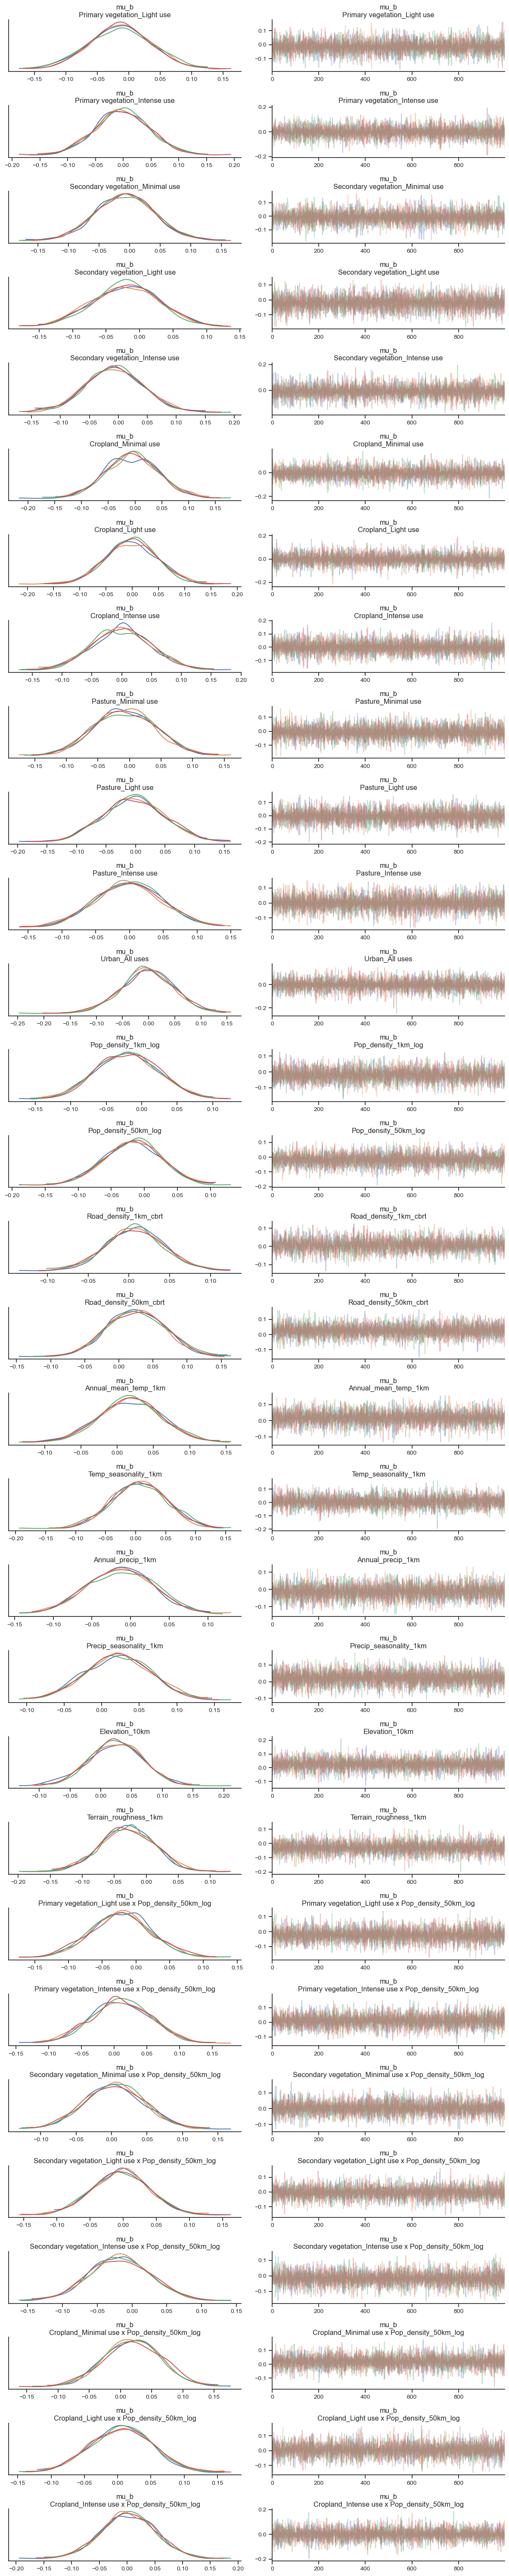

In [12]:
# Posteriors of hyperpriors: mu_beta
trace_plot(train_trace, var_names=["mu_b"])

## Energy plot

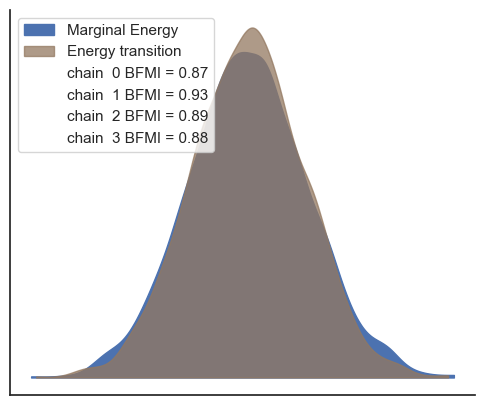

In [13]:
az.plot_energy(train_trace)
plt.show();

## Prior distribution deep dive

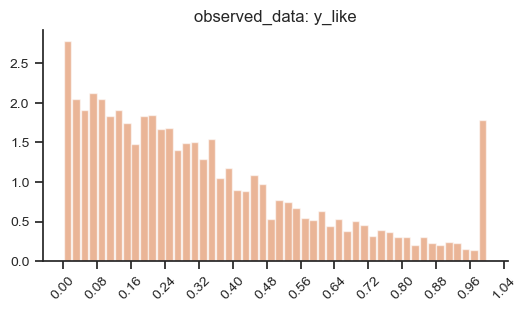

In [14]:
plot_prior_distribution(
    train_prior_predictive, category="observed_data", variable="y_like"
)

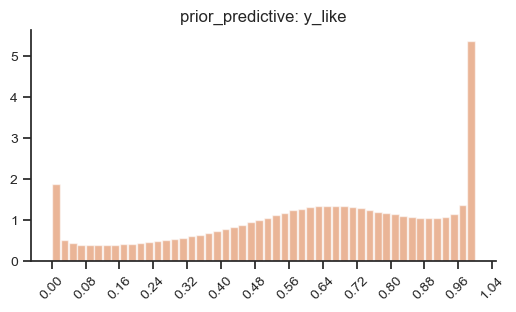

In [15]:
plot_prior_distribution(
    train_prior_predictive, category="prior_predictive", variable="y_like"
)

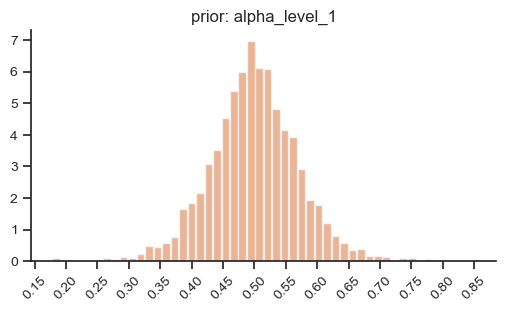

In [16]:
plot_prior_distribution(
    train_prior_predictive, category="prior", variable="alpha_level_1"
)

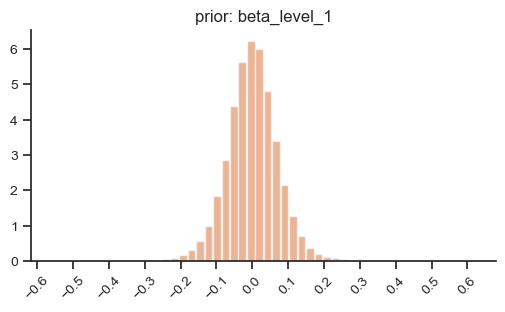

In [17]:
plot_prior_distribution(
    train_prior_predictive, category="prior", variable="beta_level_1"
)

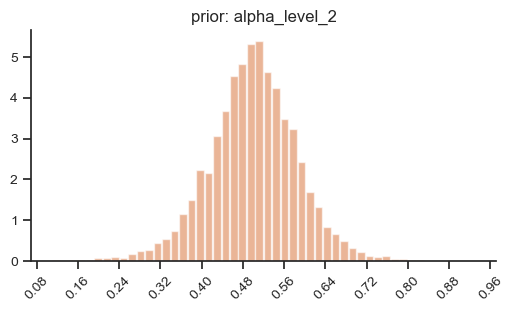

In [18]:
plot_prior_distribution(
    train_prior_predictive, category="prior", variable="alpha_level_2"
)

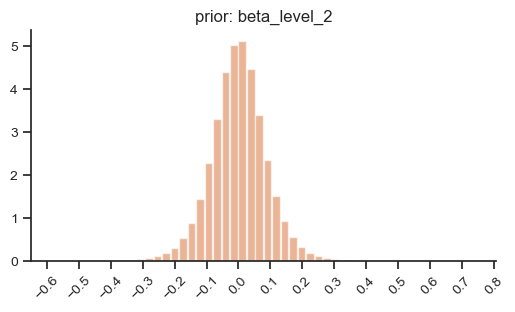

In [19]:
plot_prior_distribution(
    train_prior_predictive, category="prior", variable="beta_level_2"
)

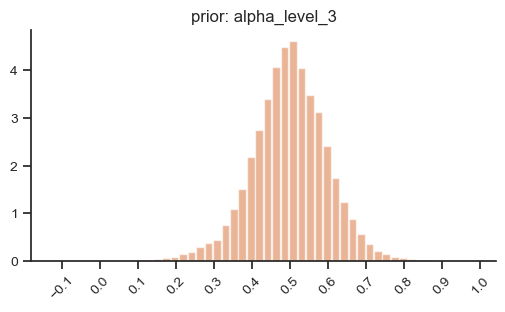

In [20]:
plot_prior_distribution(
    train_prior_predictive, category="prior", variable="alpha_level_3"
)

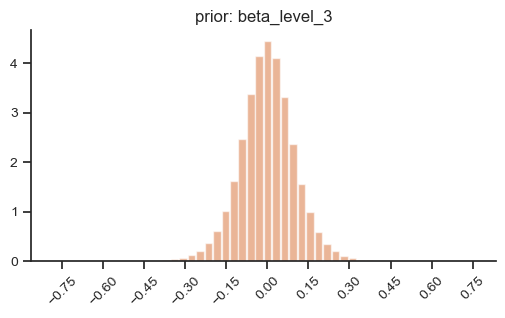

In [21]:
plot_prior_distribution(
    train_prior_predictive, category="prior", variable="beta_level_3"
)

## ESS plots

/Users/jakny386/miniconda3/envs/bio_impact/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (60) is smaller than the number of variables to plot (138) in plot_ess, generating only 60 plots
  warnings.warn(


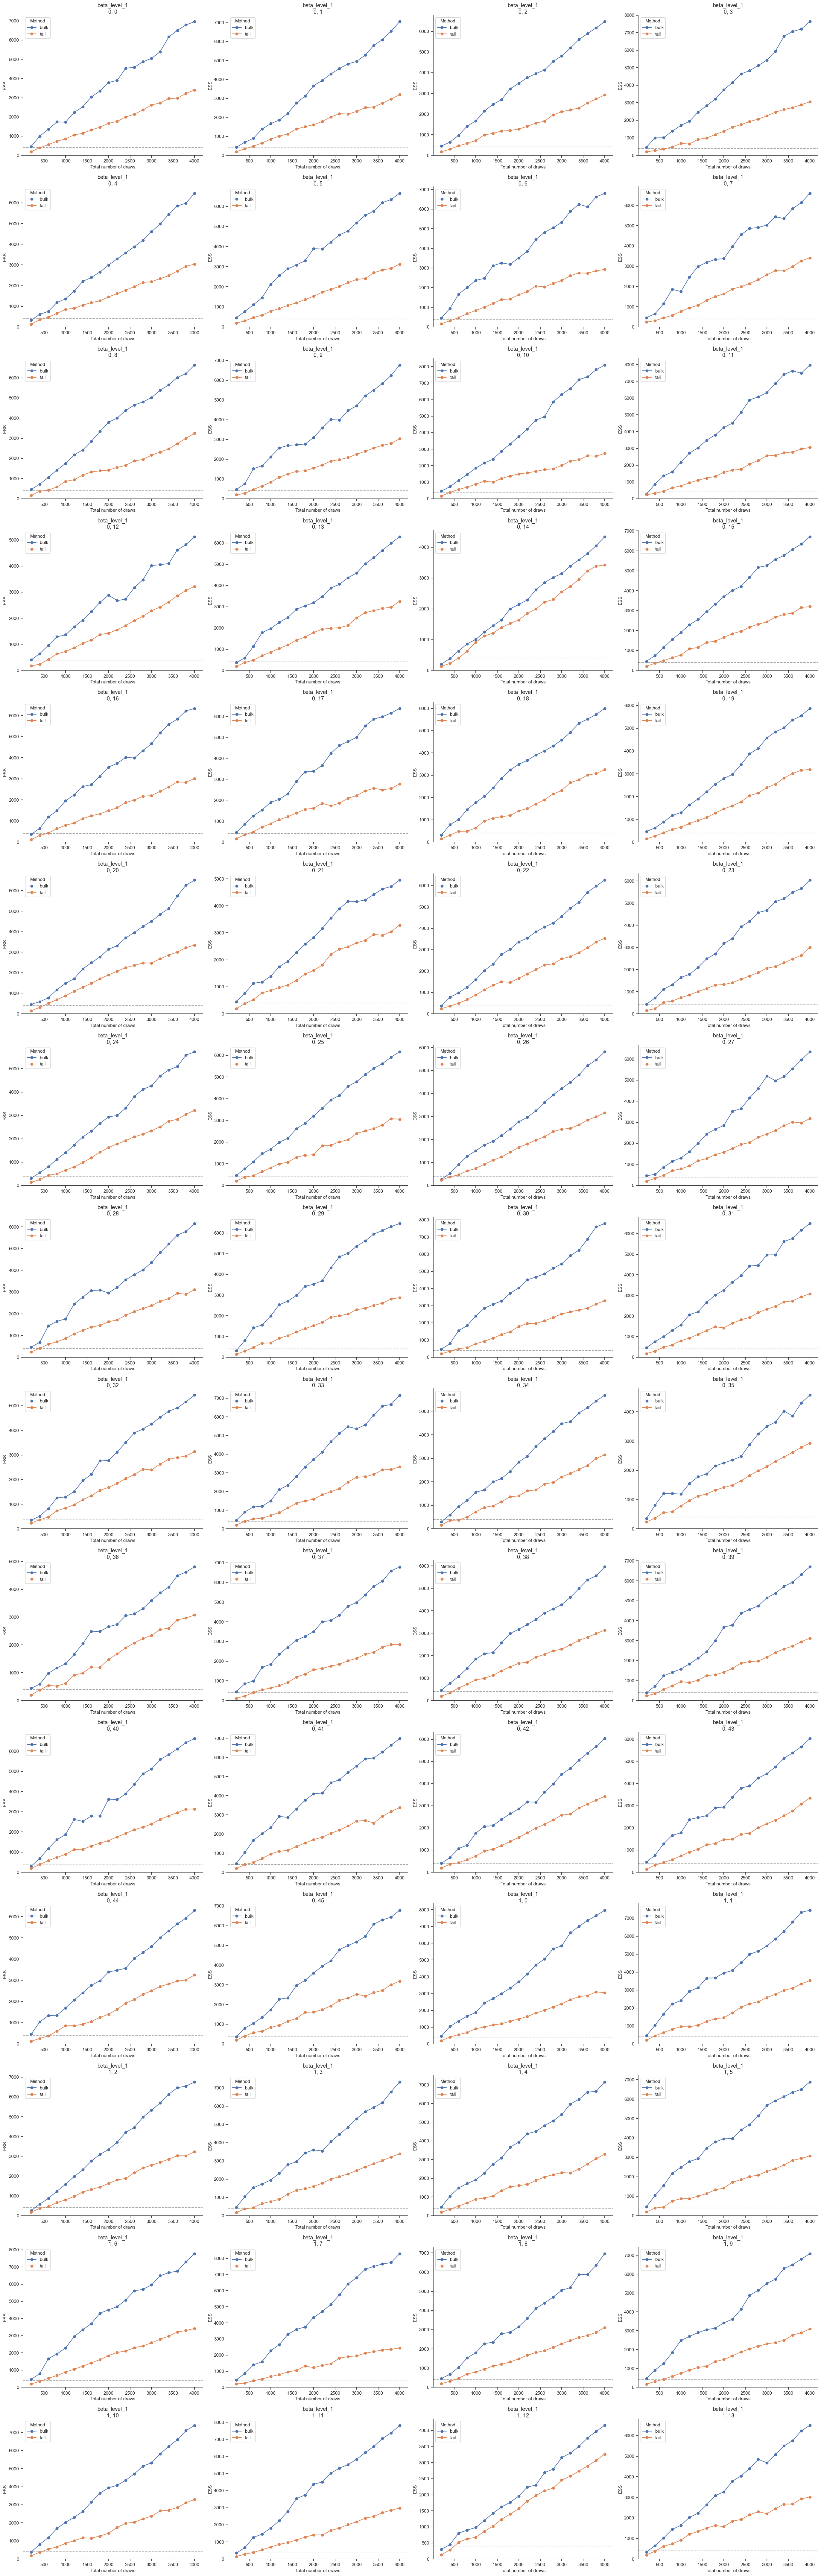

In [23]:
# ESS for posterior of hyperparameters
az.plot_ess(train_trace, kind="evolution", var_names=["beta_level_1"])
plt.tight_layout()
plt.show();

## Autocorrelation in chains

/Users/jakny386/miniconda3/envs/bio_impact/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (60) is smaller than the number of variables to plot (552) in plot_autocorr, generating only 60 plots
  warnings.warn(


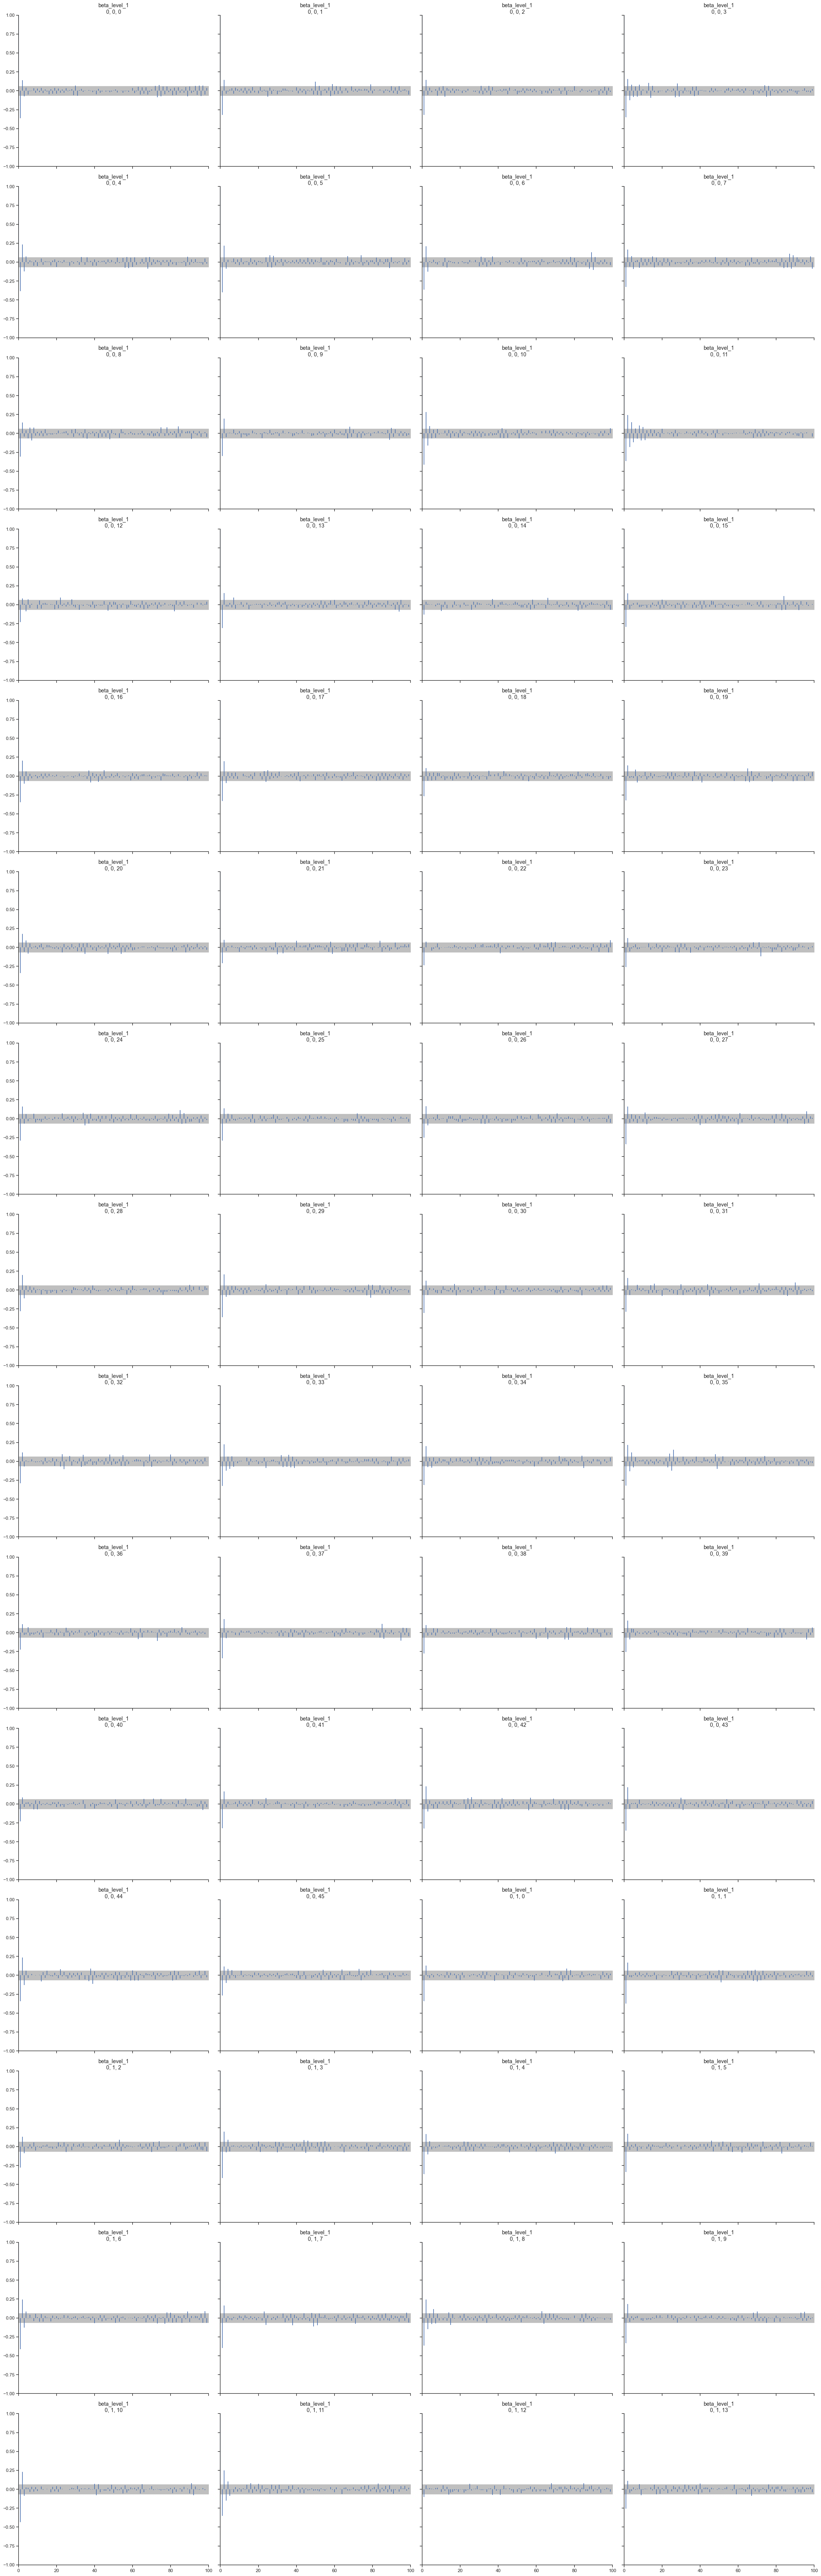

In [24]:
az.plot_autocorr(train_trace, var_names=["beta_level_1"])
plt.tight_layout();